In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn import metrics

# Visualisation données

In [2]:
final_sub = pd.read_csv('biologie/Final_sub_mean.csv', sep= ',')
final_sub = final_sub.rename(columns={'year':'DateTime'})
final_sub = final_sub[['Date', 'DC_mean', 'LC_mean', 'A_mean']]
final_sub['Date'] = final_sub['Date'].astype('datetime64[ns]')
final_sub = final_sub.rename(columns={'Date':'DateTime'})
final_sub = final_sub.dropna()
final_sub['der_DC_mean'] = final_sub['DC_mean'].diff()
final_sub

,DateTime,DC_mean,LC_mean,A_mean,der_DC_mean
4,1991-01-01,0.328800,0.324800,0.145600,NaN
5,1991-05-01,0.350496,0.372113,0.110400,0.021696
6,1992-01-01,0.390496,0.365713,0.095200,0.040000
7,1992-05-01,0.431886,0.334633,0.073600,0.041389
8,1993-01-01,0.436686,0.290633,0.060000,0.004800
...,...,...,...,...,...
89,2022-03-01,0.557133,0.178100,0.173300,0.098667
90,2022-05-01,0.503967,0.202433,0.169967,-0.053167
91,2023-03-01,0.550300,0.179267,0.176133,0.046333
92,2023-05-01,0.601000,0.171867,0.136333,0.050700


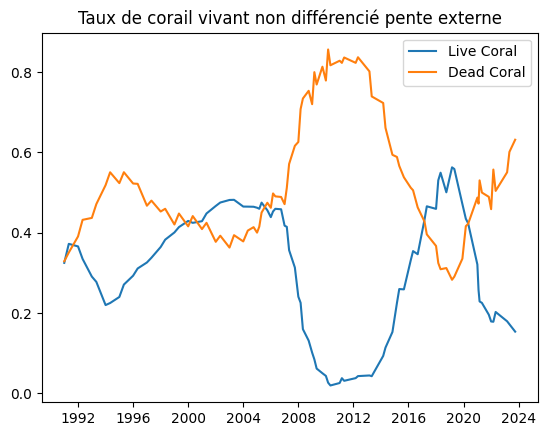

In [3]:
plt.plot(final_sub['DateTime'], final_sub['LC_mean'], label = 'Live Coral')
plt.plot(final_sub['DateTime'], final_sub['DC_mean'], label = 'Dead Coral')
#plt.plot(final_sub['DateTime'], final_sub['der_LC_mean'])
plt.title('Taux de corail vivant non différencié pente externe')
plt.legend()

In [4]:
# Filtrer les dates etoiles de mer
df_filtered = final_sub[~final_sub['DateTime'].dt.year.isin(range(2006, 2011))]

Text(0.5, 1.0, 'Évolution du taux de mortalité dans le temps')

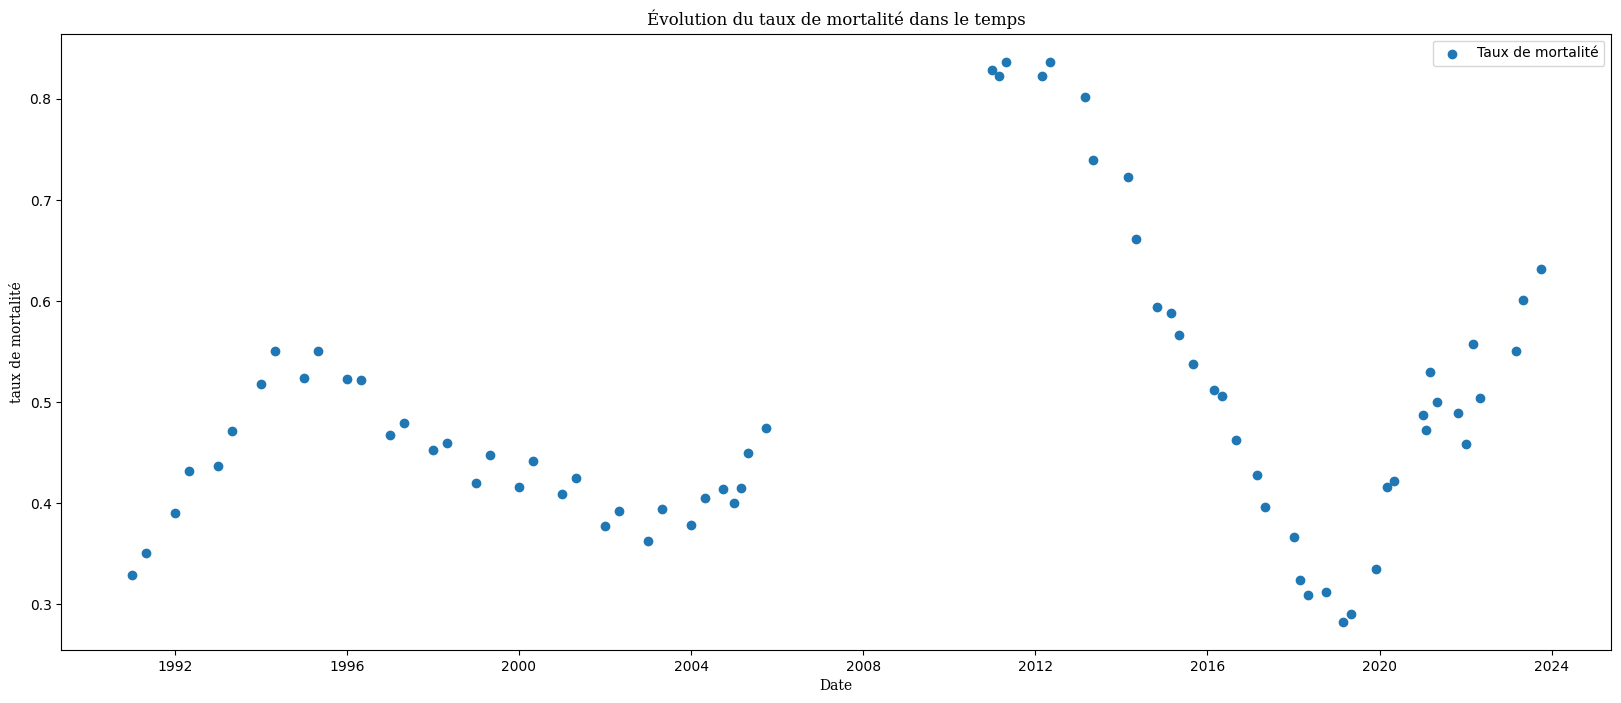

In [5]:
plt.figure(figsize=(20, 8))
plt.scatter(df_filtered['DateTime'], df_filtered['DC_mean'], label='Taux de mortalité')
plt.legend()
plt.xlabel('Date', fontfamily = 'serif')
plt.ylabel('taux de mortalité', fontfamily = 'serif')
plt.title('Évolution du taux de mortalité dans le temps', fontfamily = 'serif')

Text(0.5, 1.0, 'Évolution du gradient dans le temps')

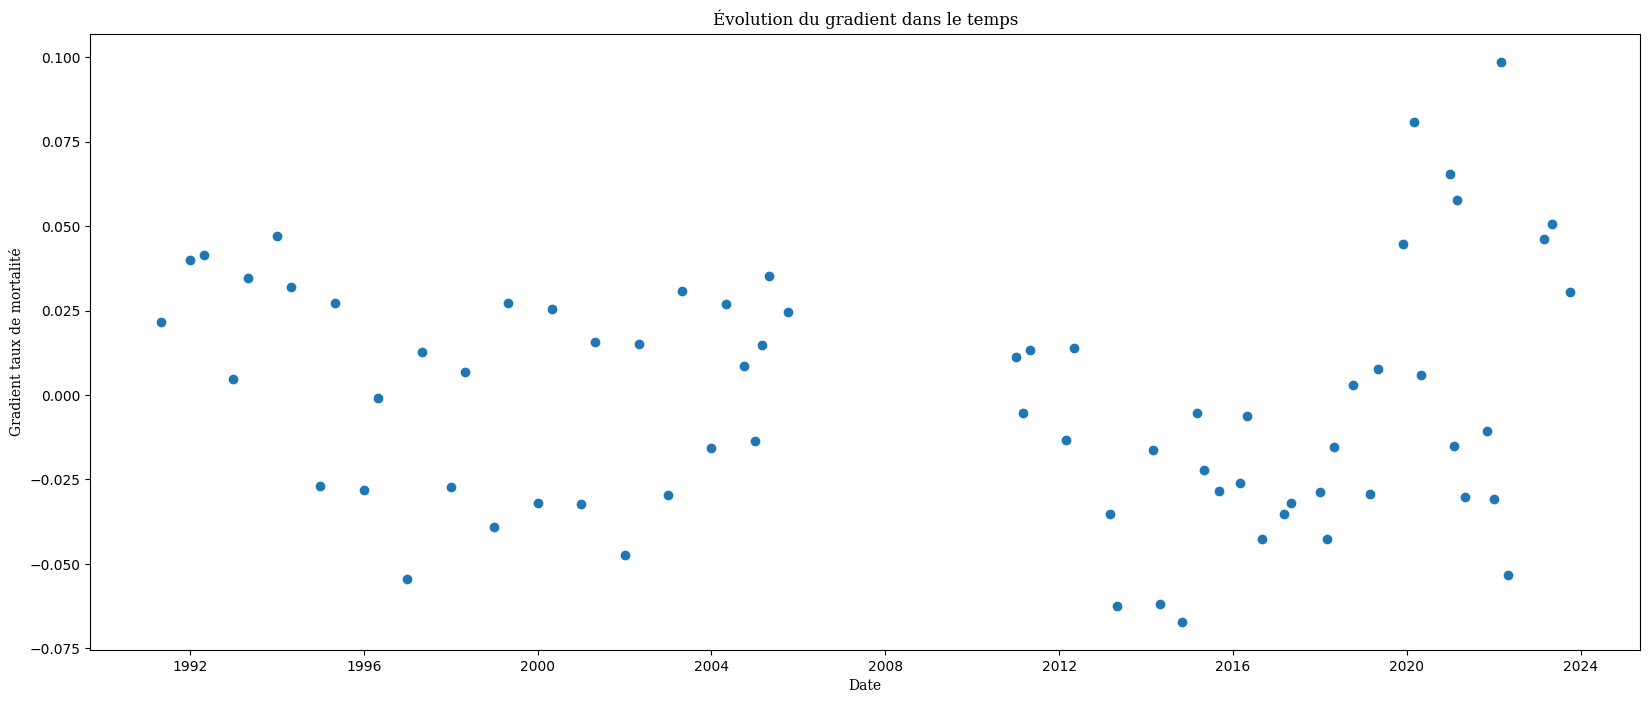

In [6]:
plt.figure(figsize=(20, 8))
plt.scatter(df_filtered['DateTime'], df_filtered['der_DC_mean'], label = 'Gradient du taux de mortalité')
plt.xlabel('Date', fontfamily = 'serif')
plt.ylabel('Gradient taux de mortalité', fontfamily = 'serif')
plt.title('Évolution du gradient dans le temps', fontfamily = 'serif')

In [7]:
fill_sst = pd.read_csv('Tableaux finaux variables/fill_sst.csv', sep = ',')
fill_sst['DateTime'] = fill_sst['DateTime'].astype('datetime64[ns]')

In [8]:
pdo = pd.read_fwf('ersst.v5.pdo.txt', widths=[4, 6 , 6, 6, 6, 6, 6 , 6, 6, 6, 6, 6, 6])
pdo.rename(columns={'ERS' : 'Year', 'ST PDO' : '01', 'Index':'02', ':':'03', 'Unnamed: 4':'04', 'Unnamed: 5':'05', 'Unnamed: 6':'06', 'Unnamed: 7':'07', 'Unnamed: 8':'08', 'Unnamed: 9':'09', 'Unnamed: 10':'10', 'Unnamed: 11':'11', 'Unnamed: 12':'12'}, inplace = True)
pdo = pdo.loc[1:]
pdo = pdo.melt(id_vars=['Year'], var_name='Mois', value_name='pdo')

# Combine les colonnes 'Annee' et 'Mois' en une seule colonne 'Annee-Mois'
pdo['DateTime'] = pd.to_datetime(pdo['Year'].astype(str) + '-' + pdo['Mois'].astype(str), format='%Y-%m')

# Supprimez les colonnes 'Annee' et 'Mois' si nécessaire
pdo = pdo.drop(columns=['Year', 'Mois'])
pdo = pdo.sort_values(by='DateTime')
pdo.reset_index(drop=True, inplace=True)
pdo['pdo'] = pdo['pdo'].astype('Float64')

In [9]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
# Paramètres de la moyenne mobile
window_size = 30

x = np.array(pdo['pdo'][pdo['DateTime'].dt.year <= 2023])
# Appliquer la moyenne mobile
x_smoothed = moving_average(x.squeeze(), window_size)

Text(0.5, 1.0, 'Évolution des Pacific Decadal Oscillations')

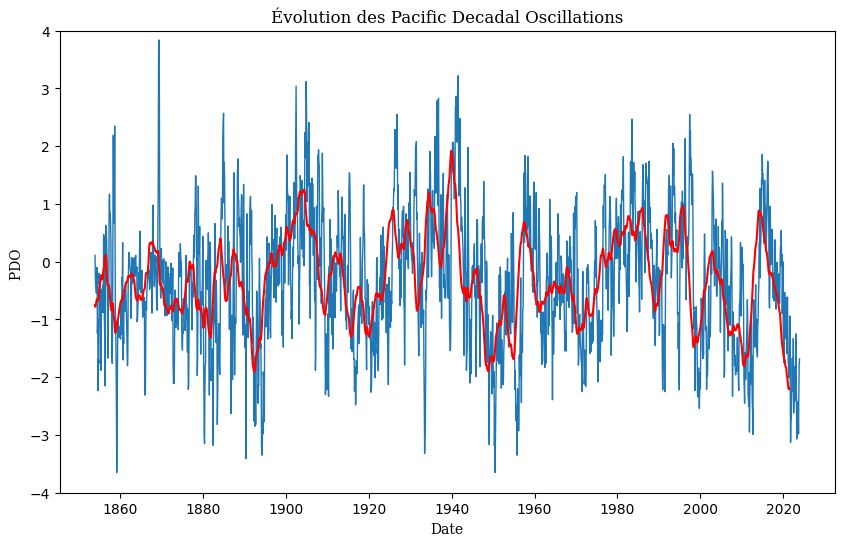

In [10]:
plt.figure(figsize = (10, 6))
plt.plot(pdo['DateTime'][pdo['DateTime'].dt.year <= 2023], pdo['pdo'][pdo['DateTime'].dt.year <= 2023], linewidth = 1)
plt.plot(pdo['DateTime'][pdo['DateTime'].dt.year <= 2023].loc[:x.shape[0] - window_size], x_smoothed, label = 'moyenne glissante', color = 'r')
plt.ylim(-4, 4)
plt.xlabel('Date', fontfamily = 'serif')
plt.ylabel('PDO ',  fontfamily = 'serif')
plt.title('Évolution des Pacific Decadal Oscillations',  fontfamily = 'serif')

In [11]:
mortalité_filtered = pd.merge(df_filtered, fill_sst, on = 'DateTime', how = 'inner')
mortalité_filtered = pd.merge(mortalité_filtered, pdo, on = 'DateTime', how = 'inner')

# Sobol Analyse

In [12]:
def s(n, variable, interet, data):

    # data = dataframe contenant toutes les variables
    # variable = nom de la colonne de la variable explicative dans data
    # interet = nom de la colonne de la variable cible dans data
    # n = nombre de bins désirées

    var_discrete = np.linspace(data[variable].min(), data[variable].max(), n)

    esperance = []
    bins = [] # contient le nombre de valeur dans chaque bins
    var_bins = [] # contient les valeurs de variables de chaque bins

    for i in range(n - 2):
        esp = data[interet][(data[variable] >= var_discrete[i])&(data[variable] < var_discrete[i + 1])].mean()
        count = data[interet][(data[variable] >= var_discrete[i])&(data[variable] < var_discrete[i + 1])].count()
        var = np.array(data[variable][(data[variable] >= var_discrete[i])&(data[variable] < var_discrete[i + 1])])
        esperance.append(esp)
        bins.append(count)
        var_bins.append(var.astype('float'))
    
    esp = data[interet][(data[variable] >= var_discrete[n - 2])&(data[variable] <= var_discrete[n - 1])].mean()
    count = data[interet][(data[variable] >= var_discrete[n - 2])&(data[variable] <= var_discrete[n - 1])].count()
    var = np.array(data[variable][(data[variable] >= var_discrete[n - 2])&(data[variable] <= var_discrete[n - 1])])
    esperance.append(esp)
    bins.append(count)
    var_bins.append(var.astype('float'))

    return(esperance, bins, var_bins)


Text(0.5, 1.0, 'Analyse Sobol DHW')

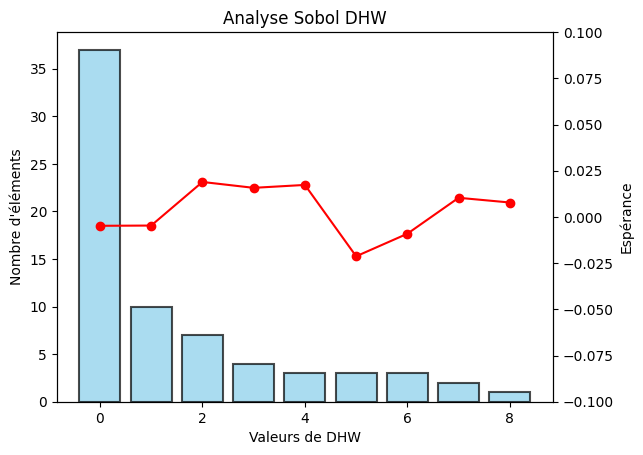

In [13]:
esperance, bins, var_bins = s(10, 'dhw', 'der_DC_mean', mortalité_filtered)

plt.bar(np.linspace(0, 8, 9), bins, color='skyblue', alpha=0.7, edgecolor='black', linewidth=1.5)
plt.ylabel('Nombre d\'éléments')
plt.xlabel('Valeurs de DHW')

# Création d'un deuxième axe pour l'histogramme
ax2 = plt.gca().twinx()

# Affichage de l'histogramme sur l'axe de droite
ax2.plot(np.linspace(0, 8, 9), esperance, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Espérance')
ax2.set_ylim(-0.1,.1)

plt.title('Analyse Sobol DHW')

Text(0.5, 1.0, 'Analyse Sobol MMM')

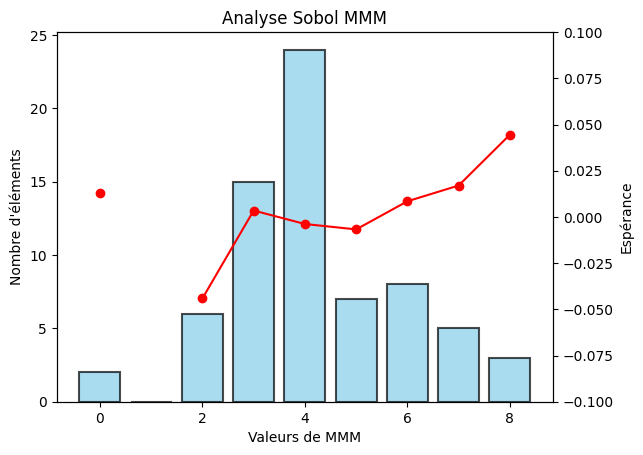

In [14]:
esperance, bins, var_bins = s(10, 'MMM', 'der_DC_mean', mortalité_filtered)

plt.bar(np.linspace(0, 8, 9), bins, color='skyblue', alpha=0.7, edgecolor='black', linewidth=1.5)
plt.ylabel('Nombre d\'éléments')
plt.xlabel('Valeurs de MMM')



# Création d'un deuxième axe pour l'histogramme
ax2 = plt.gca().twinx()

# Affichage de l'histogramme sur l'axe de droite
ax2.plot(np.linspace(0, 8, 9), esperance, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Espérance')
ax2.set_ylim(-0.1,.1)

plt.title('Analyse Sobol MMM')

Text(0.5, 1.0, 'Analyse Sobol pdo')

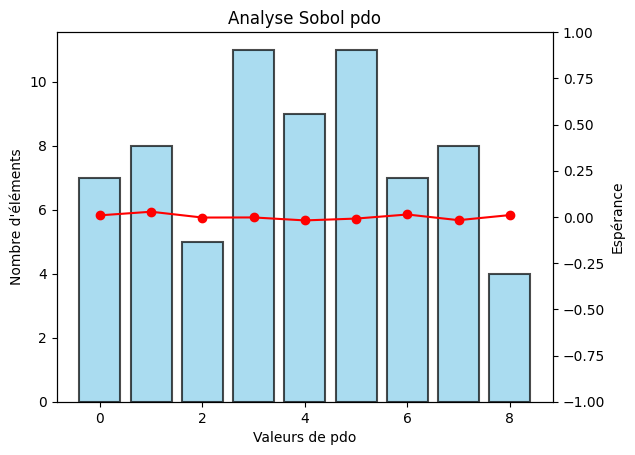

In [15]:
esperance, bins, var_bins = s(10, 'pdo', 'der_DC_mean', mortalité_filtered)

plt.bar(np.linspace(0, 8, 9), bins, color='skyblue', alpha=0.7, edgecolor='black', linewidth=1.5)
plt.ylabel('Nombre d\'éléments')
plt.xlabel('Valeurs de pdo')

# Création d'un deuxième axe pour l'histogramme
ax2 = plt.gca().twinx()

# Affichage de l'histogramme sur l'axe de droite
ax2.plot(np.linspace(0, 8, 9), esperance, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Espérance')
ax2.set_ylim(-1, 1)

plt.title('Analyse Sobol pdo')

In [16]:
def interpol(esperance, var_bins):
    var_centre = []
    for i in range(len(var_bins)):
        if len(var_bins[i]) !=0:
            var_centre.append(var_bins[i][len(var_bins[i])//2])
    
    interp_func = interp1d(var_centre, [x for x in esperance if not pd.isna(x)], kind='linear', fill_value='extrapolate')

    # Espérance interpolée pour toutes les valeurs de DHW
    esperance_interpolation = interp_func(np.unique(np.concatenate(var_bins)))

    return(esperance_interpolation, np.unique(np.concatenate(var_bins)))

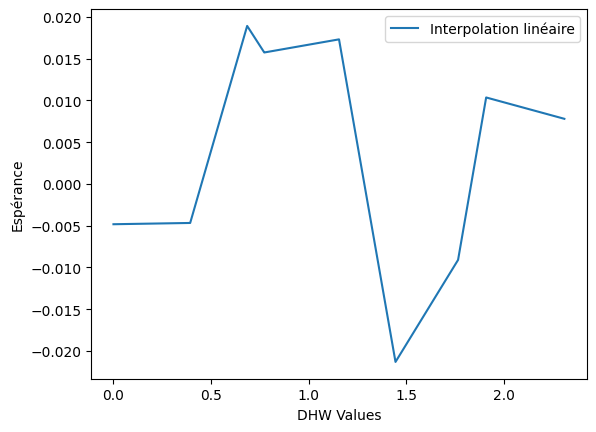

In [17]:
esperance, bins, var_bins = s(10, 'dhw', 'der_DC_mean', mortalité_filtered)
esperance_interpol, var = interpol(esperance, var_bins)
# Tracé de l'interpolation linéaire
plt.plot(var, esperance_interpol, label='Interpolation linéaire')
plt.xlabel('DHW Values')
plt.ylabel('Espérance')
plt.legend()
plt.show()


In [18]:
def F(x, esperance_interpol, val_interpol):
    for i in range(len(val_interpol)):
        if val_interpol[i] > x:
            return(esperance_interpol[i - 1])
        elif x == val_interpol[-1]:
            return(esperance_interpol[-1])
    return('erreur')

In [19]:
def sobol(n, data, variables, interet):

    # data = dataframe contenant toutes les variables
    # variables = liste des noms des colonnes des variables explicatives dans data
    # interet = nom de la colonne de la variable cible dans data
    # n = nombre de bins désirées
    variance_exp = []
    var = np.var(data[interet], ddof = 1)

    for i in range(len(variables)):
        esperance, bins, var_bins = s(n, variables[i], interet, data)
        esp = interpol(esperance, var_bins)[0]
        variance_exp.append(np.var(esp, ddof = 1)/var)
    
    return(variance_exp)

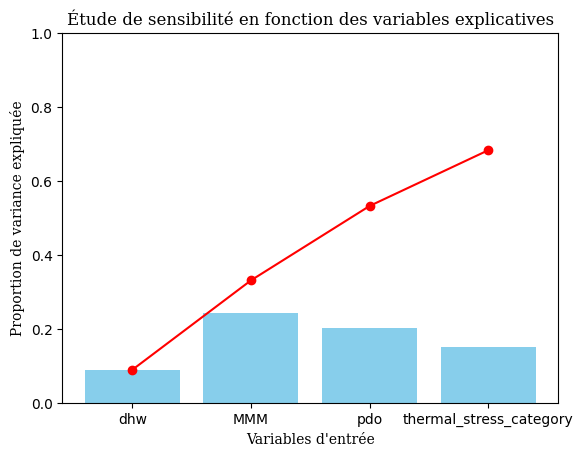

In [20]:
variables = ['dhw', 'MMM', 'pdo', 'thermal_stress_category']
interet = 'der_DC_mean'
plt.bar(variables, sobol(10, mortalité_filtered, variables, interet), color='skyblue')
plt.xlabel('Variables d\'entrée', fontfamily = 'serif')
plt.ylabel('Proportion de variance expliquée', fontfamily = 'serif')
plt.plot(variables, np.cumsum(sobol(10, mortalité_filtered, variables, interet)), color='r', marker='o', linestyle='-') 
plt.ylim(0,1)
plt.title('Étude de sensibilité en fonction des variables explicatives', fontfamily = 'serif')
plt.show()

In [21]:
# Regression
def reg(n, data, variables, interet):
    esperances = []
    val_interpol = []
    for i in range(len(variables)):
        esperance, bins, var_bins = s(n, variables[i],interet, data)
        interpolation = interpol(esperance, var_bins)
        esperances.append(interpolation[0])
        val_interpol.append(interpolation[1])
    mort = []
    vraie_mort = []
    for k in range(len(data)):
        somme = 0
        if not np.isnan(data[interet].loc[k]):
            for i in range(len(variables)):
                if F(data[variables[i]].loc[k], esperances[i], val_interpol[i]) == 'erreur':
                    print(k, i)
        
                somme += F(data[variables[i]].loc[k], esperances[i], val_interpol[i])
            mort.append(somme)
            vraie_mort.append(data[interet].loc[k] - data[interet].mean())
            
    rmse = np.sqrt(metrics.mean_squared_error(vraie_mort, mort))
    corr = np.corrcoef(vraie_mort, mort)[0, 1]
    standard_dev = np.std(np.array(vraie_mort) - np.array(mort))
    return(mort, vraie_mort, rmse, corr, standard_dev)

rmse 0.031020562920097985 corrélation 0.5326548132539402 standard deviation 0.03068559768139465


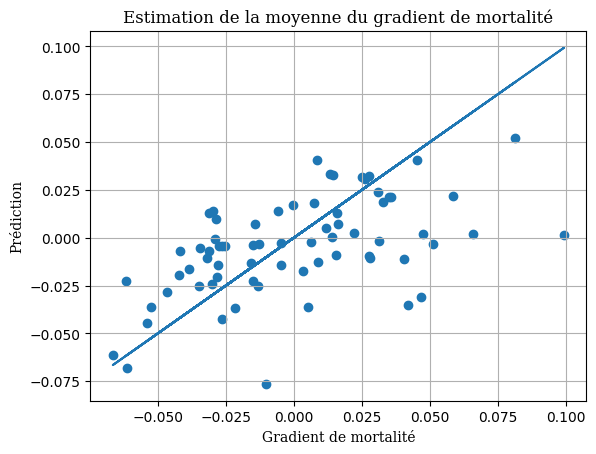

In [22]:
mort, vraie_mort, rmse, corr, standard_dev = reg(10, mortalité_filtered, ['dhw', 'MMM', 'pdo', 'thermal_stress_category'], 'der_DC_mean')
plt.scatter(vraie_mort, mort)
plt.plot(vraie_mort, vraie_mort)
plt.grid(True)
plt.xlabel('Gradient de mortalité', fontfamily = 'serif')
plt.ylabel('Prédiction', fontfamily = 'serif')
plt.title('Estimation de la moyenne du gradient de mortalité', fontfamily = 'serif')
print('rmse', rmse, 'corrélation', corr, 'standard deviation', standard_dev)

In [23]:
def prediction(n, data_train, data_test, variables, interet):
    esperances = []
    val_interpol = []
    for i in range(len(variables)):
        esperance, bins, var_bins = s(n, variables[i],interet, data_train)
        interpolation = interpol(esperance, var_bins)
        esperances.append(interpolation[0])
        val_interpol.append(interpolation[1])
    mort = []
    for k in range(len(data_test)):
        somme = 0
        if not np.isnan(data_test[interet].loc[k]):
            for i in range(len(variables)):
                if F(data_test[variables[i]].loc[k], esperances[i], val_interpol[i]) == 'erreur':
                    print(k, i)
        
                somme += F(data_test[variables[i]].loc[k], esperances[i], val_interpol[i])
            mort.append(somme)
    return(mort)

Text(0.5, 1.0, 'Estimation de la moyenne du gradient de mortalité')

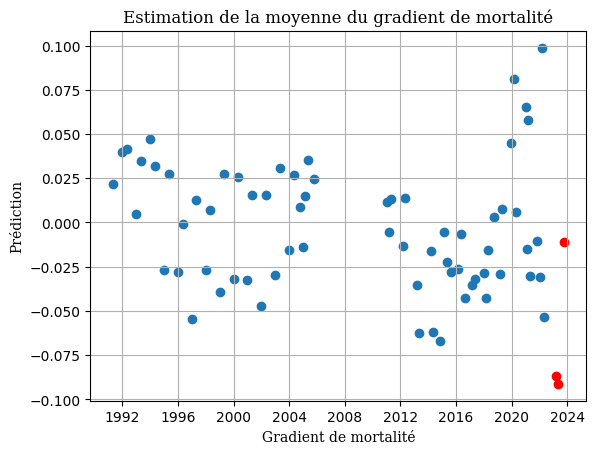

In [24]:
mort= prediction(10, mortalité_filtered[mortalité_filtered['DateTime'].dt.year <= 2022], mortalité_filtered[mortalité_filtered['DateTime'].dt.year > 2022].reset_index(drop = True), ['dhw', 'MMM', 'pdo'], 'der_DC_mean')
plt.scatter(mortalité_filtered[mortalité_filtered['DateTime'].dt.year <= 2022]['DateTime'], mortalité_filtered[mortalité_filtered['DateTime'].dt.year <= 2022]['der_DC_mean'])
plt.scatter(mortalité_filtered[mortalité_filtered['DateTime'].dt.year > 2022]['DateTime'], mort, color = 'r', label = 'Données prédites')
plt.grid(True)
plt.xlabel('Gradient de mortalité', fontfamily = 'serif')
plt.ylabel('Prédiction', fontfamily = 'serif')
plt.title('Estimation de la moyenne du gradient de mortalité', fontfamily = 'serif')


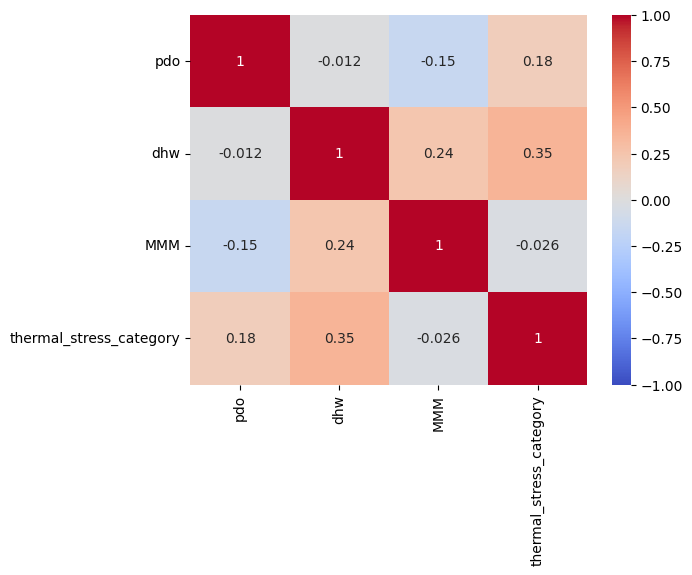

In [25]:
correlation_matrix = mortalité_filtered[['pdo', 'dhw', 'MMM', 'thermal_stress_category']].corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()